# Player Transfer Value Project – Feature Engineering + EDA

This notebook takes our **final_data_with_sentiment.csv** (already merged with Transfermarkt, injury, performance, and Reddit sentiment data) and performs:

1. **Exploratory Data Analysis (EDA)**
   - Missingness
   - Distributions
   - Correlations
2. **Feature engineering**
3. **Preprocessing pipeline**
4. **Export artifacts**

This ensures our dataset is **model-ready** and reproducible.


In [2]:
!pip install scikit-learn

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.9 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.9 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.9 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.9 MB 598.5 kB/s eta 0:00:15
   --- ------------------------------------ 0.8/8.9 MB 632.4 kB/s eta 0:00:13
   ---- ----------------------------------- 1.0/8.9 MB 751.1 kB/s eta 0:00:11
   ----- ---------------------------------- 1.3/8.9 MB 849.0 kB/s eta 0:00:09
   ------- -------------------------------- 1.6/8.9 MB 901.5 kB/s eta 0:00:09
   ------- -------------------------------- 1.6/8.9 MB 901.5 kB/s eta 0:00:09
   -------- ------------------------------- 1.8/8.9 MB 915.0 kB/s eta 0:00:08
   --------- ---------------------------

In [3]:
# --- Imports ---
import os, re, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


## 1. Load dataset


In [4]:
# Path setup
PROJECT_PATH = r"C:\Users\asing\PycharmProjects\-Dynamic-Player-Transfer-Value-Prediction-using-AI-and-Multi-source-Data-"
DATA_PATH = os.path.join(PROJECT_PATH, "processed_data", "final_data_with_sentiment.csv")

df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()


(1272, 79)


,player_id,season,avg_market_value,max_market_value,min_market_value,player_name,num_transfers,avg_transfer_fee,last_transfer_fee,avg_transfer_premium,...,Right Wing Back,Secondary Striker,num_posts,num_comments_used,pos_ratio,neu_ratio,neg_ratio,mean_compound,fallback_used,subreddits_covered
0,123951,2022,4.500000e+06,5000000.0,4000000.0,aaron mooy,NaN,NaN,NaN,NaN,...,0.0,0.0,40,41,0.0,1.0,0.0,-0.411863,False,"laliga,ligue1,soccer"
1,50057,2020,2.625000e+07,35000000.0,20000000.0,aaron ramsey,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,NaN,NaN,NaN,NaN,True,NaN
2,50057,2022,3.000000e+06,3000000.0,3000000.0,aaron ramsey,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,NaN,NaN,NaN,NaN,True,NaN
3,243633,2023,3.833333e+05,450000.0,350000.0,aaron tshibola,1.0,200000.000000,200000.0,-1.500000e+05,...,0.0,0.0,16,16,NaN,NaN,NaN,NaN,True,soccer
4,340394,2022,3.333333e+06,4000000.0,3000000.0,abdelhamid sabiri,3.0,333333.333333,1000000.0,-2.333333e+06,...,0.0,0.0,24,22,0.0,1.0,0.0,-0.727373,False,"seriea,soccer"


## 2. Quick EDA

Before feature engineering, let’s check:

- **Missing values per column**
- **Distributions of key numeric features**
- **Correlations between performance/sentiment/market value**


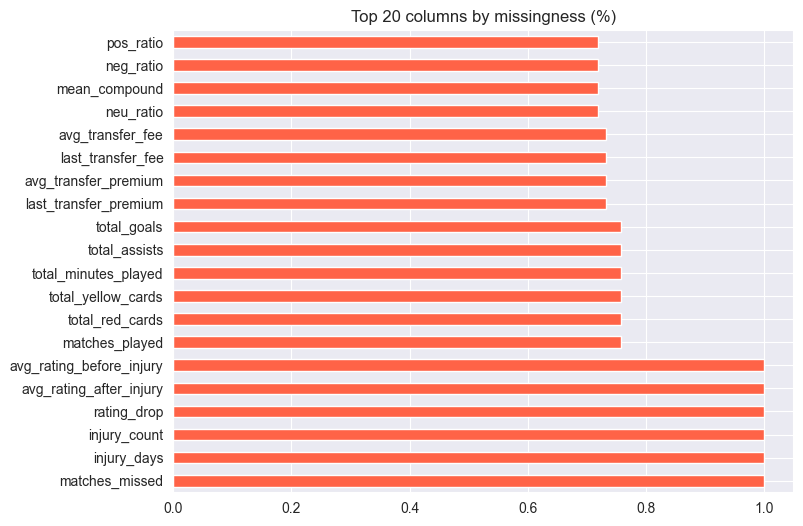

In [10]:
# --- Missingness ---
missing = df.isna().mean().sort_values(ascending=False)
plt.figure(figsize=(8,6))
missing.head(20).plot(kind="barh", color="tomato")
plt.title("Top 20 columns by missingness (%)")
# Save the plot
plt.savefig("missingness.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()


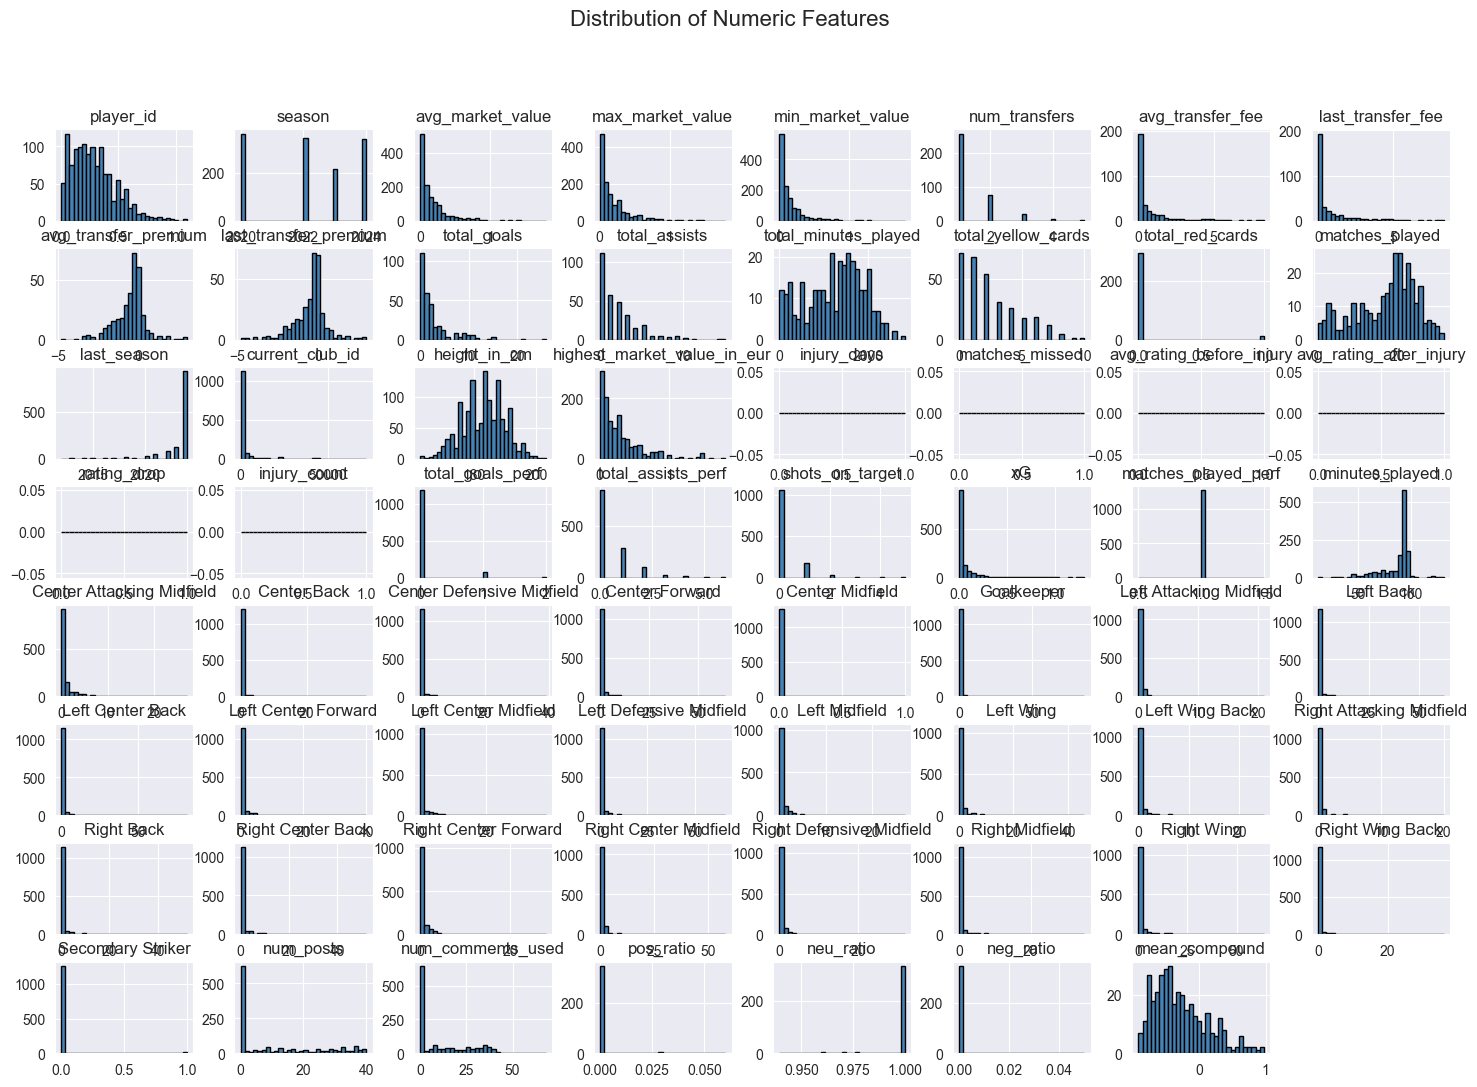

In [9]:
# --- Distributions ---
num_cols = df.select_dtypes(include=[np.number]).columns

df[num_cols].hist(bins=30, figsize=(18, 12), color="steelblue", edgecolor="black")
plt.suptitle("Distribution of Numeric Features", fontsize=16)
# Save the histogram grid
plt.savefig("numeric_distributions.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()


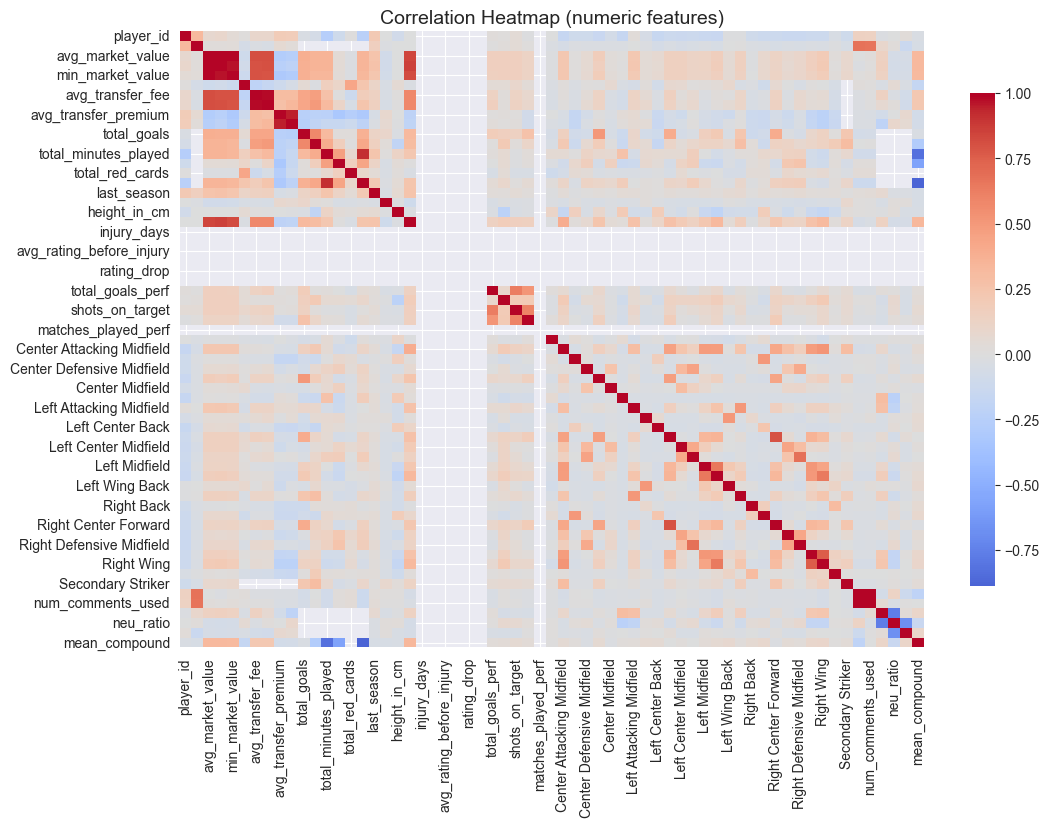

In [8]:
# --- Correlation heatmap ---
plt.figure(figsize=(12,8))
corr = df[num_cols].corr()
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False, cbar_kws={"shrink":0.8})
plt.title("Correlation Heatmap (numeric features)", fontsize=14)
# Save the figure (high resolution, white background)
plt.savefig("correlation_heatmap.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


## 3. Feature Engineering
### Design principles
- **NaNs are information**: we create *missingness indicator* features instead of blindly dropping rows/columns.
- **Leakage-aware**: the default target is `avg_market_value`. We avoid directly predicting it from trivially identical/dupe fields and keep the pipeline generic so you can pick other targets later.


In [11]:
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
import joblib

In [13]:
OUT_FEATURES = os.path.join(PROJECT_PATH, "Data_Featuring", "features.parquet")

OUT_PIPELINE = os.path.join(PROJECT_PATH, "Data_Featuring", "feature_pipeline.joblib")

In [14]:
df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head(3)


(1272, 79)


,player_id,season,avg_market_value,max_market_value,min_market_value,player_name,num_transfers,avg_transfer_fee,last_transfer_fee,avg_transfer_premium,...,Right Wing Back,Secondary Striker,num_posts,num_comments_used,pos_ratio,neu_ratio,neg_ratio,mean_compound,fallback_used,subreddits_covered
0,123951,2022,4500000.0,5000000.0,4000000.0,aaron mooy,NaN,NaN,NaN,NaN,...,0.0,0.0,40,41,0.0,1.0,0.0,-0.411863,False,"laliga,ligue1,soccer"
1,50057,2020,26250000.0,35000000.0,20000000.0,aaron ramsey,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,NaN,NaN,NaN,NaN,True,NaN
2,50057,2022,3000000.0,3000000.0,3000000.0,aaron ramsey,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,NaN,NaN,NaN,NaN,True,NaN


In [15]:
# Choose target column (market value related)
candidate_targets = [c for c in ["avg_market_value", "highest_market_value_in_euro", "max_market_value"] if c in df.columns]
target_col = candidate_targets[0] if candidate_targets else None
print("Target:", target_col)

# Identifiers (exclude from features): player_name + season
id_cols = [c for c in ["player_name", "season"] if c in df.columns]
print("ID cols:", id_cols)


Target: avg_market_value
ID cols: ['player_name', 'season']


In [16]:
class PandasFeatureBuilder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        def div(a,b): return np.where(b==0, np.nan, a/b)

        # Per-90 rates
        if "total_minutes_played" in X.columns:
            minutes = X["total_minutes_played"].astype(float).replace(0,np.nan)
            factor = minutes/90.0
            for src,name in [("total_goals","goals_per90"),("total_assists","assists_per90"),
                             ("shots_on_target","shots_on_target_per90"),("total_yellow_cards","yellow_cards_per90"),
                             ("total_red_cards","red_cards_per90")]:
                if src in X.columns:
                    X[name] = div(X[src].astype(float), factor)

        # Injuries per match
        if "matches_played" in X.columns:
            m = X["matches_played"].astype(float).replace(0,np.nan)
            if "injury_days" in X.columns:
                X["injury_days_per_match"] = div(X["injury_days"].astype(float), m)
            if "matches_missed" in X.columns:
                X["missed_ratio"] = div(X["matches_missed"].astype(float), m)

        # Sentiment composites
        for col in ["pos_ratio","neg_ratio","neu_ratio","mean_compound"]:
            if col in X.columns:
                X[col] = pd.to_numeric(X[col], errors="coerce")
        if set(["pos_ratio","neg_ratio"]).issubset(X.columns):
            X["sentiment_net"] = X["pos_ratio"] - X["neg_ratio"]
            X["sentiment_intensity"] = X["pos_ratio"] + X["neg_ratio"]
        if [c for c in ["pos_ratio","neg_ratio","neu_ratio","mean_compound"] if c in X.columns]:
            X["has_sentiment_data"] = (~X[[c for c in ["pos_ratio","neg_ratio","neu_ratio","mean_compound"] if c in X.columns]].isna().all(axis=1)).astype(int)

        # Contract expiry
        if "contract_expiration_date" in X.columns:
            dt = pd.to_datetime(X["contract_expiration_date"], errors="coerce")
            today = pd.Timestamp.today().normalize()
            X["days_to_contract_end"] = (dt - today).dt.days

        # Premium normalizations
        for fee_col in [c for c in ["avg_transfer_fee","last_transfer_fee"] if c in X.columns]:
            X[fee_col] = pd.to_numeric(X[fee_col], errors="coerce")
        if set(["avg_transfer_premium","avg_transfer_fee"]).issubset(X.columns):
            X["avg_premium_over_fee"] = div(X["avg_transfer_premium"], X["avg_transfer_fee"])
        if set(["last_transfer_premium","last_transfer_fee"]).issubset(X.columns):
            X["last_premium_over_fee"] = div(X["last_transfer_premium"], X["last_transfer_fee"])

        return X


In [17]:
# Drop identifiers + target
drop_cols = set(id_cols + ([target_col] if target_col else []))

# Split remaining columns into categorical vs numeric
feature_cols = [c for c in df.columns if c not in drop_cols]
cat_cols = [c for c in feature_cols if df[c].dtype == 'object']
num_cols = [c for c in feature_cols if c not in cat_cols]

print("Numeric cols:", len(num_cols), "Categorical cols:", len(cat_cols))


Numeric cols: 62 Categorical cols: 14


## 4. Preprocessing pipeline

In [21]:
import sklearn

sklearn_version = sklearn.__version__
print("scikit-learn version:", sklearn_version)

if sklearn_version >= "1.2":
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, min_frequency=0.01)
else:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse=False, min_frequency=0.01)


numeric_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median", add_indicator=True)),
    ("scale", RobustScaler())
])

categorical_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="constant", fill_value="__MISSING__")),
    ("onehot", encoder)
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
], remainder="drop", verbose_feature_names_out=True)

feature_pipeline = Pipeline([
    ("build_features", PandasFeatureBuilder()),
    ("preprocess", preprocess)
])


scikit-learn version: 1.7.1


In [22]:
# Drop IDs + target before fitting
X = df.drop(columns=list(drop_cols)) if drop_cols else df.copy()

Xt = feature_pipeline.fit_transform(X)

feature_names = feature_pipeline.named_steps["preprocess"].get_feature_names_out()
feat_df = pd.DataFrame(Xt, columns=feature_names, index=df.index)

# Save artifacts
feat_df.to_parquet(OUT_FEATURES, index=False)
joblib.dump(feature_pipeline, OUT_PIPELINE)

print("Saved features to features.parquet")
print("Saved pipeline to feature_pipeline.joblib")
print("Dropped columns:", drop_cols)

feat_df.head(3)


Saved features to features.parquet
Saved pipeline to feature_pipeline.joblib
Dropped columns: {'season', 'player_name', 'avg_market_value'}


,num__player_id,num__max_market_value,num__min_market_value,num__num_transfers,num__avg_transfer_fee,num__last_transfer_fee,num__avg_transfer_premium,num__last_transfer_premium,num__total_goals,num__total_assists,...,cat__player_name_norm_infrequent_sklearn,cat__player_name_perf_infrequent_sklearn,cat__subreddits_covered___MISSING__,"cat__subreddits_covered_bundesliga,soccer","cat__subreddits_covered_laliga,soccer","cat__subreddits_covered_ligue1,soccer","cat__subreddits_covered_premierleague,soccer","cat__subreddits_covered_seriea,soccer",cat__subreddits_covered_soccer,cat__subreddits_covered_infrequent_sklearn
0,-0.533554,-0.235849,-0.228571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.825201,1.179245,0.685714,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.825201,-0.330189,-0.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Integrity Checks for Saved Artifacts

Before adding new features, we validate whether the saved artifacts (`features.parquet`, `feature_pipeline.joblib`) are intact.
This step ensures that we didn’t accidentally transpose or corrupt the feature table.


In [25]:
from pathlib import Path
import pandas as pd
import joblib
import os

PROJECT_PATH = Path(PROJECT_PATH)

OUT_FEATURES = PROJECT_PATH / "Data_Featuring" / "features.parquet"
OUT_PIPELINE = PROJECT_PATH / "Data_Featuring" / "feature_pipeline.joblib"
OUT_CSV_FALLBACK = PROJECT_PATH / "Data_Featuring" / "features_fallback.csv.gz"

print("Artifacts exist?")
print(" - features.parquet:", OUT_FEATURES.exists())
print(" - feature_pipeline.joblib:", OUT_PIPELINE.exists())
print(" - fallback csv:", OUT_CSV_FALLBACK.exists())

if OUT_FEATURES.exists():
    try:
        feat_df = pd.read_parquet(OUT_FEATURES)
        print("features.parquet shape:", feat_df.shape)
    except Exception as e:
        print("Could not read features.parquet:", e)
        feat_df = None
elif OUT_CSV_FALLBACK.exists():
    feat_df = pd.read_csv(OUT_CSV_FALLBACK, compression="gzip")
    print("Loaded fallback CSV shape:", feat_df.shape)
else:
    print("No features file found.")
    feat_df = None

if feat_df is not None:
    print("Columns sample:", feat_df.columns[:20].tolist())
    print("N rows (should match df.shape[0]):", feat_df.shape[0])


Artifacts exist?
 - features.parquet: True
 - feature_pipeline.joblib: True
 - fallback csv: False
features.parquet shape: (1272, 264)
Columns sample: ['num__player_id', 'num__max_market_value', 'num__min_market_value', 'num__num_transfers', 'num__avg_transfer_fee', 'num__last_transfer_fee', 'num__avg_transfer_premium', 'num__last_transfer_premium', 'num__total_goals', 'num__total_assists', 'num__total_minutes_played', 'num__total_yellow_cards', 'num__total_red_cards', 'num__matches_played', 'num__last_season', 'num__current_club_id', 'num__height_in_cm', 'num__highest_market_value_in_eur', 'num__total_goals_perf', 'num__total_assists_perf']
N rows (should match df.shape[0]): 1272


### Parse Season into Numeric Order

We need a numeric season ordering to compute rolling averages and lag features.


In [29]:
import re
import numpy as np
import pandas as pd
from pathlib import Path

def parse_season_to_year(season):
    if pd.isna(season):
        return np.nan
    s = str(season)
    m = re.search(r'(\d{4})', s)
    if m:
        return int(m.group(1))
    try:
        return int(float(s))
    except:
        return np.nan

# create/overwrite season_order (safe)
if 'season' in df.columns:
    df['season_order'] = df['season'].apply(parse_season_to_year)
else:
    df['season_order'] = np.nan

df['season_order'] = pd.to_numeric(df['season_order'], errors='coerce')
print("season_order min/max:", df['season_order'].min(), df['season_order'].max())


season_order min/max: 2020 2024


### Rolling Features (Trends)

Add rolling averages/counts over the last 1 and 3 seasons for key performance metrics.
This captures improvement/decline trajectories.


In [30]:
import numpy as np
import pandas as pd

def safe_div(num, denom):
    num = pd.to_numeric(num, errors='coerce')
    denom = pd.to_numeric(denom, errors='coerce').replace(0, np.nan)
    return num / denom

# Create per-90 on raw df if missing (so rolling uses same base features)
if 'total_minutes_played' in df.columns:
    minutes = pd.to_numeric(df['total_minutes_played'], errors='coerce').replace(0, np.nan)
    if 'goals_per90' not in df.columns and 'total_goals' in df.columns:
        df['goals_per90'] = safe_div(df['total_goals'], minutes/90)
    if 'assists_per90' not in df.columns and 'total_assists' in df.columns:
        df['assists_per90'] = safe_div(df['total_assists'], minutes/90)
    if 'shots_on_target_per90' not in df.columns and 'shots_on_target' in df.columns:
        df['shots_on_target_per90'] = safe_div(df['shots_on_target'], minutes/90)

# List of candidate performance columns (only keep those present)
perf_candidates = ["goals_per90","assists_per90","total_minutes_played","total_goals","total_assists","injury_days","matches_played","shots_on_target_per90"]
perf_cols = [c for c in perf_candidates if c in df.columns]

roll_windows = [1, 3]  # previous 1 and 3 seasons

# compute rolling **previous** seasons (shift(1) to avoid leakage) using transform -> aligned
for w in roll_windows:
    for c in perf_cols:
        mean_col = f"{c}_roll{w}_mean_prev"
        count_col = f"{c}_roll{w}_count_prev"

        # mean of last w previous seasons (shift first to avoid including current season)
        df[mean_col] = df.groupby('player_name')[c].transform(lambda s: s.shift(1).rolling(window=w, min_periods=1).mean())

        # count of non-null entries in that window (helps imputer)
        df[count_col] = df.groupby('player_name')[c].transform(lambda s: s.shift(1).rolling(window=w, min_periods=0).count())

print("Added rolling features sample:", [col for col in df.columns if '_roll' in col][:12])


Added rolling features sample: ['total_minutes_played_roll1_mean_prev', 'total_minutes_played_roll1_count_prev', 'total_goals_roll1_mean_prev', 'total_goals_roll1_count_prev', 'total_assists_roll1_mean_prev', 'total_assists_roll1_count_prev', 'injury_days_roll1_mean_prev', 'injury_days_roll1_count_prev', 'matches_played_roll1_mean_prev', 'matches_played_roll1_count_prev', 'total_minutes_played_roll3_mean_prev', 'total_minutes_played_roll3_count_prev']


### Injury Exponential Decay

Recent injuries should weigh more than old ones. We build an `injury_decay_score`.


In [31]:
decay_lambda = 0.8  # tune later (0 < alpha < 1)
inj_col = 'injury_days' if 'injury_days' in df.columns else None

if inj_col:
    # shift so we only use *past* seasons, then apply EWM per player (transform keeps index)
    df['injury_decay_score'] = df.groupby('player_name')[inj_col].transform(
        lambda s: s.shift(1).ewm(alpha=decay_lambda, adjust=False).mean()
    )
    df['injury_decay_score'] = pd.to_numeric(df['injury_decay_score'], errors='coerce').fillna(0)
    print("Created injury_decay_score (filled NaN -> 0)")
else:
    print("No injury column found; skipping injury decay.")


Created injury_decay_score (filled NaN -> 0)


### Contract bucketing (safe numeric coercion)

In [32]:
# Contract bucketing
if 'days_to_contract_end' in df.columns:
    df['days_to_contract_end'] = pd.to_numeric(df['days_to_contract_end'], errors='coerce')
    bins = [-1e9, 183, 365, 730, 1e9]   # <6m, 6-12m, 12-24m, >24m
    labels = ['<6m','6-12m','12-24m','>24m']
    df['contract_bucket'] = pd.cut(df['days_to_contract_end'], bins=bins, labels=labels)
    print("contract_bucket value counts:")
    print(df['contract_bucket'].value_counts(dropna=False))
else:
    print("days_to_contract_end not found; skipping contract buckets.")


days_to_contract_end not found; skipping contract buckets.


### Sentiment × performance interactions (safe numeric multiplication)

In [33]:
sent_cols = [c for c in ['sentiment_net','sentiment_intensity','mean_compound'] if c in df.columns]
perf_interact_cols = [c for c in ['goals_per90','assists_per90','shots_on_target_per90','total_goals','total_assists'] if c in df.columns]

new_interactions = []
for s in sent_cols:
    for p in perf_interact_cols:
        newc = f"{p}_x_{s}"
        # coerce to numeric to avoid dtype errors; multiplication preserves NaNs
        df[newc] = pd.to_numeric(df[p], errors='coerce') * pd.to_numeric(df[s], errors='coerce')
        new_interactions.append(newc)

print("Added interaction columns (sample):", new_interactions[:10])


Added interaction columns (sample): ['goals_per90_x_mean_compound', 'assists_per90_x_mean_compound', 'shots_on_target_per90_x_mean_compound', 'total_goals_x_mean_compound', 'total_assists_x_mean_compound']


### Candidate high-correlation detection (on combined features)

In [34]:
import numpy as np
from pathlib import Path

# Ensure feat_df exists (transform again if needed)
if 'feat_df' not in globals():
    # recreate feat_df using the saved pipeline if available
    X_input = df.drop(columns=list(drop_cols)) if drop_cols else df.copy()
    feat_arr = feature_pipeline.transform(X_input)
    feature_names = feature_pipeline.named_steps["preprocess"].get_feature_names_out()
    feat_df = pd.DataFrame(feat_arr, columns=feature_names, index=df.index)

# Determine new columns created in df that we want to include in correlation checks
new_cols = [c for c in df.columns if ('_roll' in c) or ('injury_decay' in c) or ('contract_bucket' in c) or ('_x_' in c)]

# Build combined table (feat_df + new engineered columns)
combined = feat_df.join(df[new_cols], how='left')

# correlation only on numeric columns (ignore object/categorical)
numeric_cols = combined.select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_cols) > 1:
    corr = combined[numeric_cols].corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    threshold = 0.95
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
else:
    to_drop = []

# Save candidate list for auditing
OUT_DIR = Path(PROJECT_PATH) / "Data_Featuring" if 'PROJECT_PATH' in globals() else Path("Data_Featuring")
OUT_DIR.mkdir(parents=True, exist_ok=True)
hc_path = OUT_DIR / "high_corr_drop_candidates.csv"
pd.Series(to_drop).to_csv(hc_path, index=False)
print(f"High-correlation candidates saved ({len(to_drop)}):", hc_path)


High-correlation candidates saved (76): C:\Users\asing\PycharmProjects\-Dynamic-Player-Transfer-Value-Prediction-using-AI-and-Multi-source-Data-\Data_Featuring\high_corr_drop_candidates.csv


## 4. Saving Final artifact

### Merge new features into feat_df, drop flagged cols and save final artifacts

In [35]:
from pathlib import Path

OUT_DIR = Path(PROJECT_PATH) / "Data_Featuring" if 'PROJECT_PATH' in globals() else Path("Data_Featuring")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# joined matrix (feat_df already numeric + encoded columns) + new engineered columns from df
new_cols = [c for c in df.columns if ('_roll' in c) or ('injury_decay' in c) or ('contract_bucket' in c) or ('_x_' in c)]
feat_df_aug = feat_df.join(df[new_cols], how='left')

# Drop high-correlation candidates that exist in the augmented feature set
hc_path = OUT_DIR / "high_corr_drop_candidates.csv"
if hc_path.exists():
    hc = pd.read_csv(hc_path, header=None).iloc[:,0].dropna().astype(str).tolist()
    hc_present = [c for c in hc if c in feat_df_aug.columns]
    if hc_present:
        feat_df_aug = feat_df_aug.drop(columns=hc_present)
        print("Dropped high-correlation candidates (present):", len(hc_present))
    else:
        print("No high-correlation candidates were present in augmented features.")
else:
    print("No high-corr candidate file found; nothing dropped automatically.")

# Save final augmented features
aug_parquet = OUT_DIR / "features_augmented.parquet"
aug_csv = OUT_DIR / "features_augmented.csv.gz"

try:
    feat_df_aug.to_parquet(aug_parquet, index=False)
    print("Saved:", aug_parquet)
except Exception as e:
    # fallback to gz CSV if parquet engine missing
    feat_df_aug.to_csv(aug_csv, index=False, compression='gzip')
    print("Parquet save failed; saved gzip CSV:", aug_csv)

print("Final augmented features shape:", feat_df_aug.shape)
feat_df_aug.head(3)


Dropped high-correlation candidates (present): 76
Saved: C:\Users\asing\PycharmProjects\-Dynamic-Player-Transfer-Value-Prediction-using-AI-and-Multi-source-Data-\Data_Featuring\features_augmented.parquet
Final augmented features shape: (1272, 226)


,num__player_id,num__max_market_value,num__num_transfers,num__avg_transfer_fee,num__avg_transfer_premium,num__total_goals,num__total_assists,num__total_minutes_played,num__total_yellow_cards,num__total_red_cards,...,injury_days_roll1_count_prev,matches_played_roll1_mean_prev,total_minutes_played_roll3_count_prev,injury_days_roll3_mean_prev,injury_days_roll3_count_prev,goals_per90_roll1_mean_prev,assists_per90_roll1_mean_prev,shots_on_target_per90_roll1_mean_prev,injury_decay_score,goals_per90_x_mean_compound
0,-0.533554,-0.235849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN
1,-0.825201,1.179245,0.0,0.0,0.0,1.0,1.0,-335.0,1.0,0.0,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN
2,-0.825201,-0.330189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,24.0,1.0,NaN,0.0,0.17425,0.17425,0.0,0.0,NaN


# featuring is done and augmented dataset is ready for modeling — it has:

1. Trend-aware features (seasonal rollings),

2. Injury risk signals,

3. Contract buckets,

4. Sentiment × performance interactions,

5. And correlation pruning to avoid multicollinearity.